In [2]:
using Pkg
Pkg.activate("rad_transfer"; shared=true)
using RadiativeTransfer
using RadiativeTransfer.CrossSection
using KernelAbstractions
using ..Architectures
using Pkg.Artifacts
using ProgressMeter
using DataStructures
using PyPlot

include("julia_cs_matrix_helper.jl")
# include("/home/cchristo/proj_christian/RadiativeTransfer.jl/src/CrossSection/types.jl")


 Activating environment at `~/.julia/environments/rad_transfer/Project.toml`
 Activating environment at `~/.julia/environments/rad_transfer/Project.toml`


get_cross_section_matrix (generic function with 1 method)

In [3]:
include("julia_cs_matrix_helper.jl")

 Activating environment at `~/.julia/environments/rad_transfer/Project.toml`


get_cross_section_matrix (generic function with 1 method)

In [4]:
using NetCDF
using NCDatasets

In [5]:
# reanalysis_file_path = "/export/data2/groupMembers/cchristo/reanalysis_3d/merra2/2015/01/MERRA2_400.tavg3_3d_asm_Nv.20150101.nc4"
ave_reanalysis_file_path = "/export/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/profile_djf_week.nc"

"/export/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/profile_djf_week.nc"

In [11]:
# ds = Dataset(ave_reanalysis_file_path)

## Open Profile and Extract Profile for a Time

In [6]:
# ds = ncread(reanalysis_file_path)
ds = Dataset(ave_reanalysis_file_path)

# times = ds["time"][:] 
lats = ds["lat"][:]
lons = ds["lon"][:]
T = ds["T"][:]
P = ds["PL"][:]
# (lon, lat, z, time)
var_array_sizes = size(T)

T_prof = T[:]
P_prof = P[:] / 100

72-element Array{Float32,1}:
   0.0150000015
   0.02635001
   0.040142514
   0.05679252
   0.077672526
   0.10452403
   0.13959901
   0.18542203
   0.24493755
   0.32178348
   0.4204236
   0.54629266
   0.70595664
   ⋮
 563.6065
 571.22
 578.80804
 586.39575
 593.98065
 601.5559
 609.1061
 616.6516
 624.19116
 631.7227
 639.24445
 647.8926

In [178]:
# P_prof


In [5]:
# ncinfo(reanalysis_file_path)
desired_lat = 72.5796
desired_lon = -38.4588

# find index of nearest gridcell
lat_ind = argmin(broadcast(abs, lats .- desired_lat))
lon_ind = argmin(broadcast(abs, lons .- desired_lon))

# set time ind
time_ind = 1

T_prof = T[lat_ind,lon_ind, :,time_ind]
P_prof = P[lat_ind,lon_ind, :,time_ind]

72-element Array{Union{Missing, Float32},1}:
     1.5000001f0
     2.6350012f0
     4.014251f0
     5.679252f0
     7.7672524f0
    10.452404f0
    13.959901f0
    18.542204f0
    24.493753f0
    32.17835f0
    42.04236f0
    54.62927f0
    70.59567f0
     ⋮
 79832.53f0
 81252.28f0
 82670.94f0
 84089.055f0
 85507.18f0
 86924.695f0
 88340.86f0
 89760.266f0
 91180.53f0
 92595.586f0
 94014.875f0
 95438.945f0

In [5]:
# fetch('H2O_S',1,1,xmin,xmax)
# fetch('CO2_S',2,1,xmin,xmax)
# fetch('CH4_S',6,1,xmin,xmax)

In [7]:
hitran_data_CO2 = read_hitran("hitran_molec_id_2_CO2.tar", mol=2, iso=1, ν_min=400, ν_max=2100)
hitran_data_H2O = read_hitran("hitran_molec_id_1_H2O.tar", mol=1, iso=1, ν_min=400, ν_max=2100)
hitran_data_CH4 = read_hitran("hitran_molec_id_6_CH4.tar", mol=6, iso=1, ν_min=400, ν_max=2100)

HitranTable{Float64}
  mol: Array{Int64}((58893,)) [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
  iso: Array{Int64}((58893,)) [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  νᵢ: Array{Float64}((58893,)) [400.416314, 400.500621, 400.515163, 400.545478, 400.783489, 400.847081, 400.941244, 401.101872, 401.494615, 401.738456  …  2098.001522, 2098.224403, 2098.558601, 2099.174328, 2099.274806, 2099.389535, 2099.440549, 2099.731408, 2099.87477, 2099.931237]
  Sᵢ: Array{Float64}((58893,)) [2.055e-30, 2.836e-30, 2.834e-30, 3.576e-30, 6.418e-30, 1.242e-30, 2.422e-30, 1.379e-30, 1.891e-30, 1.795e-30  …  8.137e-28, 1.592e-27, 7.599e-29, 9.206e-29, 3.743e-29, 6.561e-29, 5.98e-29, 7.884e-28, 5.626e-28, 2.94e-29]
  Aᵢ: Array{Float64}((58893,)) [1.727e-7, 1.481e-5, 1.568e-6, 1.997e-7, 6.715e-7, 1.102e-8, 2.125e-8, 1.21e-8, 1.572e-6, 0.001561  …  0.04187, 0.04916, 0.003913, 0.004716, 0.001916, 0.003381, 0.003082, 0.04041, 0.04324, 0.001502]
  γ_air: Array{Float64}(

In [10]:
compute_absorption_cross_section(hitran_data_CO2, Voigt(), collect(ν_grid), p_grid[10], t_grid[10], architecture=Architectures.GPU())

MethodError: MethodError: no method matching array_type(::RadiativeTransfer.Architectures.GPU)
Closest candidates are:
  array_type(!Matched::RadiativeTransfer.Architectures.CPU) at /home/cchristo/.julia/packages/RadiativeTransfer/oaa4w/src/Architectures.jl:46

In [15]:
# Architectures.GPU()
length(collect(ν_grid))

170000

In [17]:
@time compute_absorption_cross_section(hitran_data_H2O, Voigt(), collect(ν_grid), p_grid[10], t_grid[10], 
    wing_cutoff = 10, architecture=Architectures.CPU())

  0.827135 seconds (371.60 k allocations: 20.741 MiB)


170000-element Array{Float64,1}:
 8.105992926430678e-25
 8.848973497721656e-25
 9.702326170683607e-25
 1.068939663360468e-24
 1.184009316235715e-24
 1.3193240576085501e-24
 1.4799986191169247e-24
 1.6728841026729157e-24
 1.9073372896863975e-24
 2.1964775731124944e-24
 2.560880442422643e-24
 3.025535929744301e-24
 3.624131385750509e-24
 ⋮
 4.771445786877706e-28
 5.706441176637313e-28
 7.167258587007436e-28
 9.48541734518984e-28
 1.3400876263739417e-27
 2.0739346008278435e-27
 3.703067861034713e-27
 8.652034457280058e-27
 6.708046843865339e-26
 4.931815385326592e-23
 3.6217607924350535e-26
 7.648519460231518e-27

In [ ]:
@time begin
model_interp = make_interpolation_model(hitran_data_CO2, Voigt(), ν_grid, pressures, temperatures)
    
end

Computing Cross Sections for Interpolation... 20%|█▎    |  ETA: 0:03:14

In [9]:
ν_grid = 400:0.01:2099.99
p_grid = P_prof[:]
t_grid = T_prof[:]

72-element Array{Union{Missing, Float32},1}:
 202.94925f0
 207.71889f0
 217.35593f0
 226.02596f0
 231.42293f0
 236.14986f0
 241.20515f0
 245.34897f0
 247.8092f0
 250.66423f0
 255.77087f0
 259.24652f0
 263.36966f0
   ⋮
 240.66661f0
 241.12915f0
 241.60477f0
 242.0822f0
 242.54677f0
 242.99382f0
 243.38539f0
 243.70296f0
 244.0438f0
 243.74142f0
 244.11185f0
 237.36955f0

In [85]:
# @time begin
# CO2_cs_matrix = get_cross_section_matrix(hitran_data_CO2, ν_grid, p_grid, t_grid)
# end

In [ ]:
CO2_cs_matrix = get_cross_section_matrix(hitran_data_CO2, ν_grid, p_grid, t_grid)
H2O_cs_matrix = get_cross_section_matrix(hitran_data_H2O, ν_grid, p_grid, t_grid)
CH4_cs_matrix = get_cross_section_matrix(hitran_data_CH4, ν_grid, p_grid, t_grid)

Computing Cross Sections for Interpolation...100%|██████| Time: 0:07:27
Computing Cross Sections for Interpolation...100%|██████| Time: 0:02:04
Computing Cross Sections for Interpolation... 54%|███▎  |  ETA: 0:05:26

In [141]:
out_file_path = "/export/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/cs_matrix_djf_week_julia.nc"

"/export/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/cs_matrix_djf_week_julia.nc"

In [142]:
ds = Dataset(out_file_path,"c")

NCDataset: /export/data2/groupMembers/cchristo/cs_matrices/summit_seasonal/cs_matrix_djf_week_julia.nc
Group: /



In [143]:
nu_dim = defDim(ds,"nu", size(ν_grid)[1])
pres_dim = defDim(ds,"pressure", size(p_grid)[1])



# Define the variables temperature with the attribute units
CO2_cs_matrix_var = defVar(ds,"cs_matrix_co2", Float64, ("pressure", "nu"))
H2O_cs_matrix_var = defVar(ds, "cs_matrix_h2o", Float64, ("pressure", "nu"))
CH4_cs_matrix_var = defVar(ds,"cs_matrix_ch4", Float64, ("pressure", "nu"))
# nu_coord = defVar(ds,"nu", Float64, ("nu"))
# pres_coord = defVar(ds,"pressure", Float64, ("pressure"))
# nu_coord = coord(ds,"nu", Float64, ("nu"))

CO2_cs_matrix_var = CO2_cs_matrix
H2O_cs_matrix_var = H2O_cs_matrix
CH4_cs_matrix_var = CH4_cs_matrix

# nu_coord = collect(ν_grid)
# pres_coord = p_grid


close(ds)

closed NetCDF NCDataset

10.0

In [151]:
# broadcast(max,CO2_cs_matrix)
findmax(CO2_cs_matrix)

(1.2424183217493597e-16, CartesianIndex(1, 26801))

In [152]:
findmin(CO2_cs_matrix)

(0.0, CartesianIndex(2, 1))

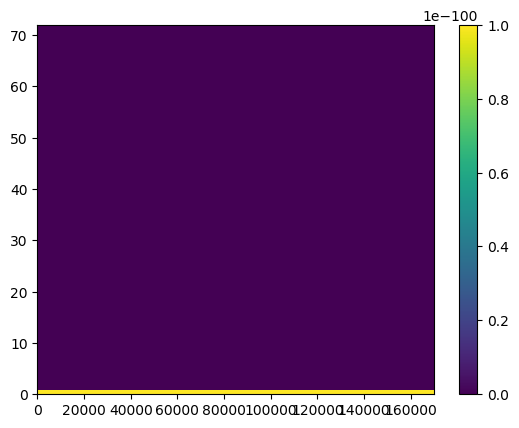

PyObject <matplotlib.colorbar.Colorbar object at 0x7fca1a22c0b8>

In [180]:
pcolormesh(H2O_cs_matrix, vmax = 10^-100)
colorbar()